In [2]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve
from scipy.interpolate import RectBivariateSpline
from BurgerSolver import get_burger_solver

In [3]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

grid,solver = get_burger_solver(alpha,kappa,k,n = 1999)

u0 = func_u0(grid)[1:-1]

sols,tvals = solver(u0,1.01)
sols = np.hstack([np.zeros((len(sols),1)),sols,np.zeros((len(sols),1))])

  0%|          | 0/2019 [00:00<?, ?it/s]

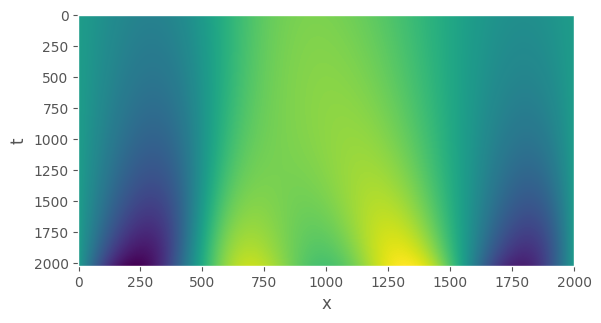

In [4]:
plt.imshow(sols[::-1],aspect = 0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)

In [5]:
interp = RectBivariateSpline(tvals,grid,sols)
def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)

def ut_true_function(x):
    ut_interp = interp.partial_derivative(1,0)
    return ut_interp(x[:,0],x[:,1],grid = False)

In [6]:
def build_tx_grid(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary

def build_tx_grid_chebyshev(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    nodes = jnp.cos(jnp.pi*(2*jnp.arange(0,num_grid_x,1)[::-1])/(2*(num_grid_x-1)))
    reg_grid = jnp.linspace(-1,1,num_grid_x)
    alpha = 0.6
    nodes = alpha * nodes + (1-alpha) * reg_grid
    # nodes = jnp.sign(nodes)*jnp.abs(nodes)**(5/4)
    full_x_grid = (nodes  + (x_range[0]+1))/(2*(x_range[1]-x_range[0]))
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary


In [7]:
num_grid_x = 26
num_grid_t = 26

tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x)

tx_all = jnp.vstack([tx_bdy,tx_int])

init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)


u_true = u_true_function(tx_all)

num_obs = 40
np.random.seed(40)

remaining_inds = list(
    set(list(np.arange(len(tx_int)))) - 
    set(list(np.where(tx_int[:,0]==0)[0]))
)

x_t_sample_inds = np.random.choice(remaining_inds,num_obs,replace = False)
x_t_sample_inds = jnp.hstack([init_obs_inds,x_t_sample_inds])

tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])

u_obs = u_true_function(tx_obs)


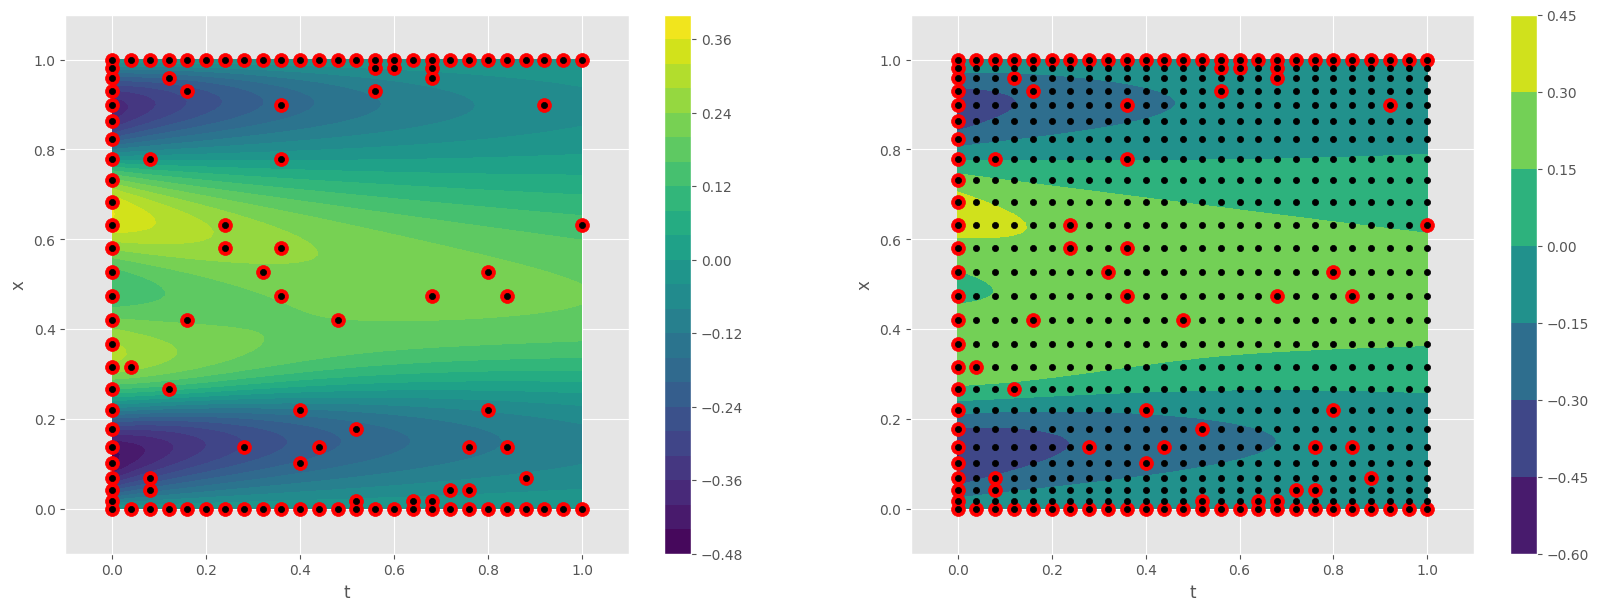

In [8]:
num_fine_grid = 100
final_time = 1
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.subplot(1,2,2)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine))
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)

plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

Text(0.5, 1.0, 'Input Data')

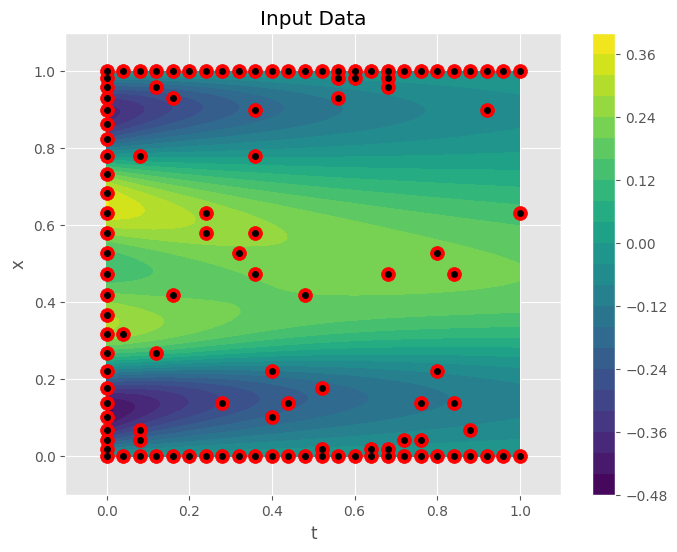

In [9]:
plt.figure(figsize=(8,6))
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Input Data")

In [10]:
# Kt = get_kernel_block_ops(get_gaussianRBF(0.001),[eval_k],[eval_k])(jnp.linspace(0,1,500),jnp.linspace(0,1,500))
# samples = np.random.multivariate_normal(jnp.zeros(len(Kt)),Kt,10)
# plt.figure(figsize=(24,5))
# for s in samples[:2]:
#     plt.plot(jnp.linspace(0,1,500),s)

# Kt = get_kernel_block_ops(get_gaussianRBF(0.001),[eval_k],[eval_k])(jnp.linspace(0,1,26),jnp.linspace(0,1,500))
# plt.figure(figsize=(20,5))
# for krow in Kt:
#     plt.plot(krow)

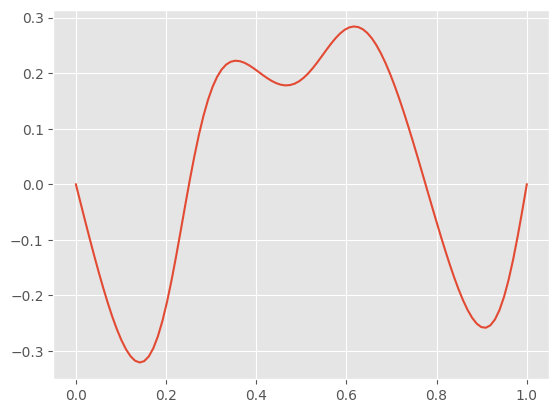

In [11]:
grid_points = jnp.linspace(0,1,100)
plot_views = jnp.vstack([0.2*jnp.ones(100),grid_points]).T

plt.plot(grid_points,u_true_function(plot_views))

In [13]:
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel

u_operators = [eval_k,dx_k,dt_k]
feature_operators = [eval_k,dx_k,dxx_k]


k_u = get_gaussianRBF(0.025)#get_sum_of_kernels([get_gaussianRBF(0.05),get_gaussianRBF(0.2)],coefficients=[0.5,0.5])#get_gaussianRBF(0.1)

u_model = InducedRKHS(
    tx_all,
    feature_operators,
    k_u
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params

class EqnModel():
    datafit_weight = 10

    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
        grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
        return grid_features
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators([dt_k],tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_obs,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = EqnModel.eval_obs_points(u_params)
        return u_obs - obs_preds
    
    @jit
    def equation_residual(full_params):
        u_params = full_params[:u_model.num_params]
        P_params = full_params[u_model.num_params:]
        P_features = EqnModel.get_grid_features(u_params)
        P_model_preds = P_model.predict(P_features,P_params)
        ugrid_target = EqnModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(full_params):
        u_params = full_params[:u_model.num_params]
        eqn_res = EqnModel.equation_residual(full_params)
        data_res = EqnModel.datafit_residual(u_params)
        return jnp.hstack([
            EqnModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(full_params):
        return jnp.linalg.norm(EqnModel.F(full_params))**2
    
    @jit
    def damping_matrix(full_params):
        u_params = full_params[:u_model.num_params]
        grid_feats = EqnModel.get_grid_features(u_params)
        kmat_P = P_model.kernel_function(grid_feats,grid_feats)
        dmat = block_diag(
            u_model.kmat+1e-3 * diagpart(u_model.kmat),
            1e-3 * (kmat_P+1e-3 * jnp.identity(len(kmat_P)))
        )
        return dmat

2024-04-27 13:04:22.207088: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.363 = f64[676,676]{1,0} reduce(f64[676,676,2]{2,1,0} %broadcast.178, f64[] %constant.9), dimensions={2}, to_apply=%region_10.359, metadata={op_name="jit(k_super)/jit(main)/reduce_sum[axes=(2,)]" source_file="/home/alexh/KEQL/keql/keql_tools/Kernels.py" source_line=6}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-04-27 13:04:22.209491: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.002513406s
Constant folding an instruction is taking > 1s:

  %reduce.363 = f64[676,

In [14]:
init_feats = EqnModel.get_grid_features(u_params_init)
KP_init = P_model.kernel_function(init_feats,init_feats)
P_params_init = solve(KP_init+1e-4 * diagpart(KP_init),EqnModel.get_grid_target(u_params_init))

In [15]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack([u_params_init,0 * P_params_init])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-9,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.02119, Jres = 100.6, alpha = 0.08333, improvement_ratio = 0.9212
Iteration 1, loss = 0.003807, Jres = 161.4, alpha = 0.06944, improvement_ratio = 0.9808
Iteration 2, loss = 0.00225, Jres = 12.52, alpha = 0.05787, improvement_ratio = 0.9966
Iteration 3, loss = 0.001691, Jres = 3.864, alpha = 0.04823, improvement_ratio = 0.9996
Iteration 4, loss = 0.001373, Jres = 1.738, alpha = 0.04019, improvement_ratio = 1.0
Iteration 5, loss = 0.00116, Jres = 0.7685, alpha = 0.03349, improvement_ratio = 1.001
Iteration 50, loss = 2.593e-05, Jres = 5.407, alpha = 6.079e-05, improvement_ratio = 0.5281
Iteration 100, loss = 1.493e-05, Jres = 0.7592, alpha = 5.351e-05, improvement_ratio = 0.7056
Iteration 150, loss = 1.333e-05, Jres = 0.2411, alpha = 5.351e-05, improvement_ratio = 0.4859
Iteration 200, loss = 1.237e-05, Jres = 0.4371, alpha = 5.351e-05, improvement_ratio = 0.3648
Iteration 250, loss = 1.168e-05, Jres = 0.3385, alpha = 5.351e-05, improvement_ratio = 0.2767
Iteration 

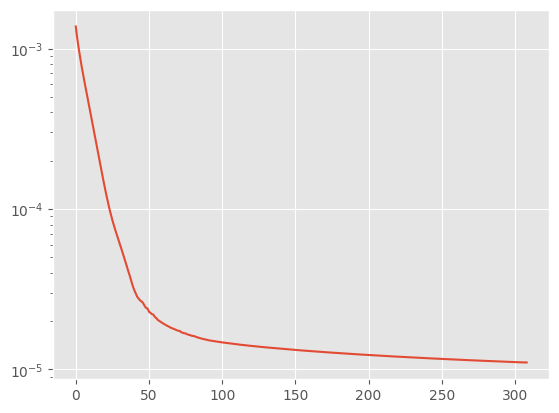

In [16]:
plt.plot(loss_vals[5:])
plt.yscale('log')

In [17]:
hess_loss = jit(jax.hessian(EqnModel.loss))
gradloss = jit(jax.grad(EqnModel.loss))

In [18]:
importlib.reload(LM_Solve)
from LM_Solve import refine_solution
reg_sequence = np.hstack(
    [
        10 ** jnp.arange(-1, -5, -0.1),
        5e-6 * np.ones(20),
        1e-6 * np.ones(20),
        10 ** jnp.arange(-5, -7, -0.1),
        10 ** jnp.arange(-6, -13, -0.05),
        1e-14 * jnp.ones(20),
        1e-15 * jnp.ones(25),
        2e-16 * jnp.ones(25)
        ]
        )
p_adjusted,refinement_losses = refine_solution(params,EqnModel,reg_sequence)

  0%|          | 0/310 [00:00<?, ?it/s]

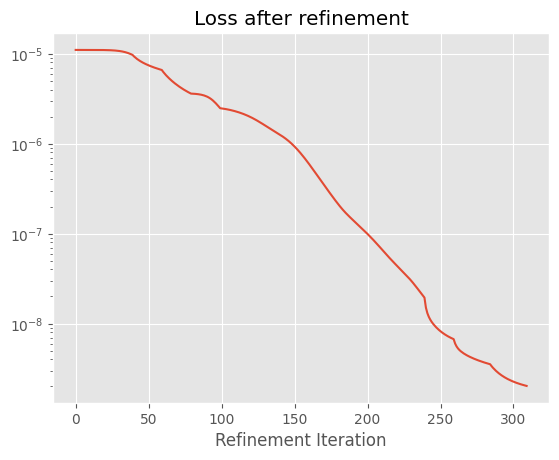

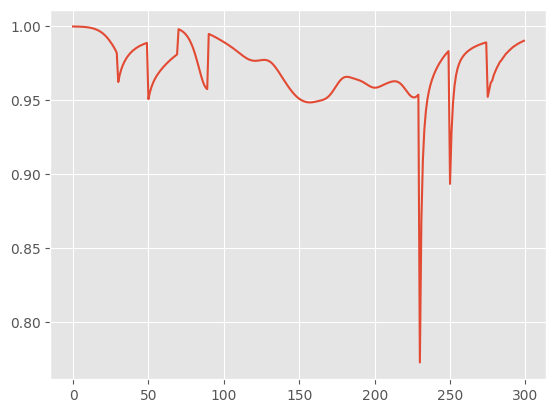

In [19]:
plt.plot(refinement_losses)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')
plt.show()
plt.plot(refinement_losses[10:]/refinement_losses[9:-1])



/tmp/ipykernel_82200/811041060.py:1: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([loss_vals,refinement_losses]))


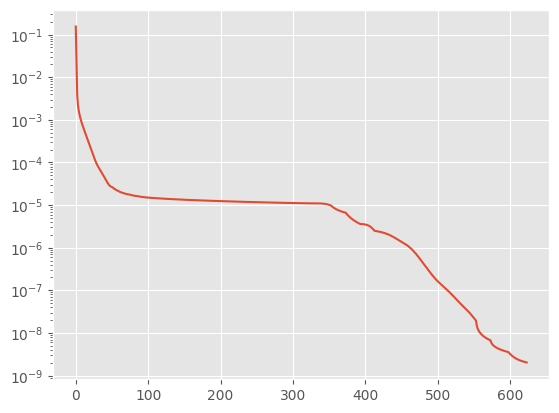

In [20]:
plt.plot(jnp.hstack([loss_vals,refinement_losses]))
plt.yscale('log')

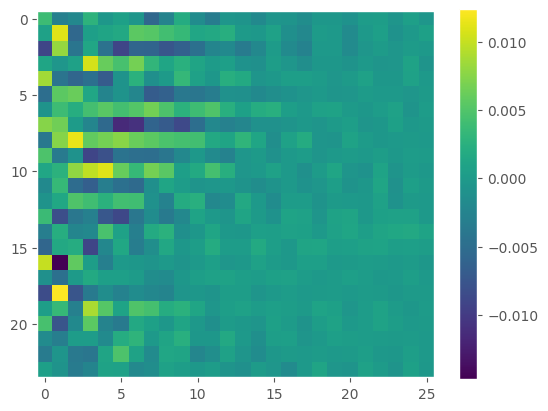

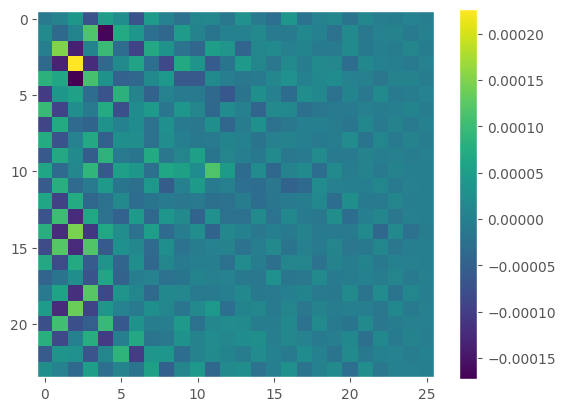

Pre Refinement  9.044707049894756e-06
Post Refinement  1.6627844678268296e-09


In [21]:
equation_residuals = EqnModel.equation_residual(params)
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()

equation_residuals_refined = EqnModel.equation_residual(p_adjusted)
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()
print("Pre Refinement ",jnp.mean(equation_residuals**2))
print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

In [22]:
# analyze_hessian(hess_loss(p_adjusted),gradloss(p_adjusted))

In [23]:
# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]

# u_sol = p_adjusted[:u_model.num_params]
# P_sol = p_adjusted[u_model.num_params:]

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

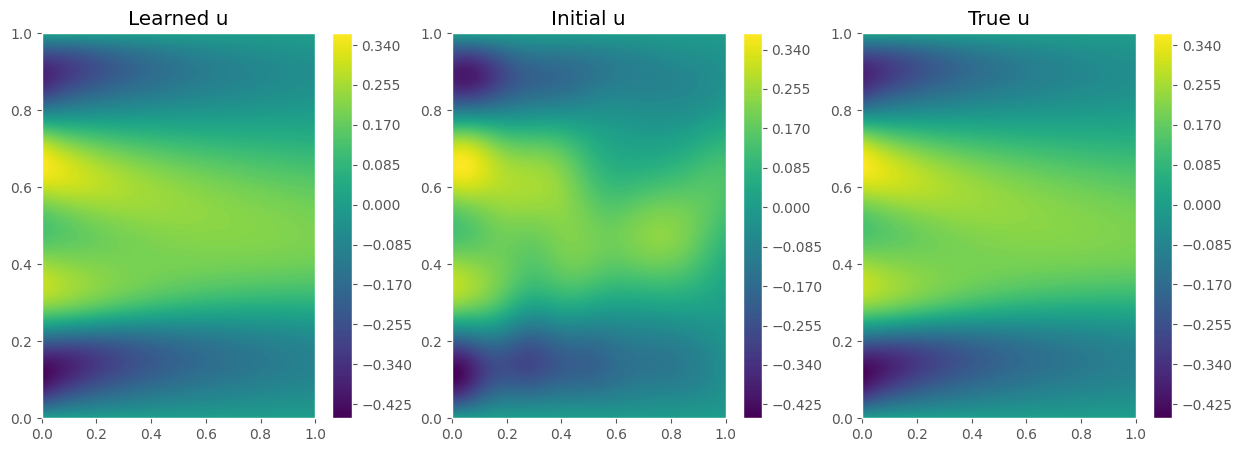

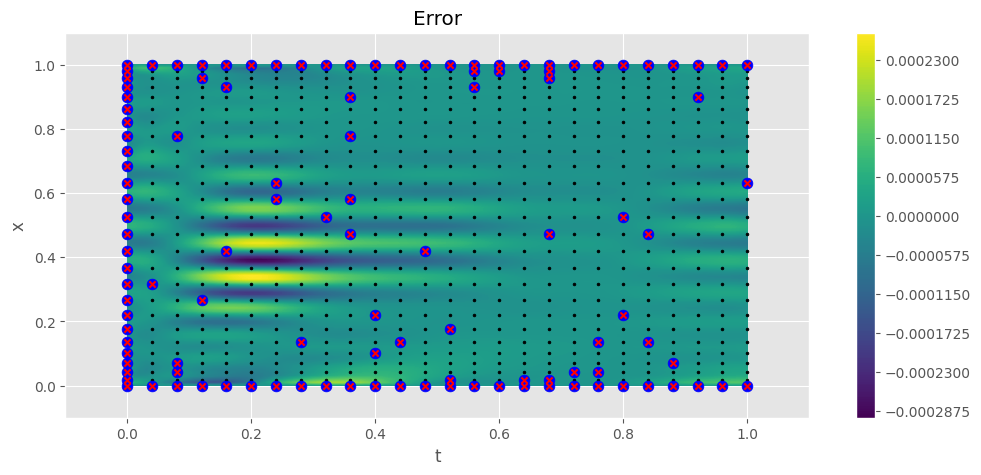

In [24]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)

u_true_fine = u_true_function(tx_grid_fine)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_eval_fine,200)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Initial u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_model.point_evaluate(tx_grid_fine,u_params_init),200)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine,200)
plt.colorbar()

plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='blue',s = 60)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 20,marker = 'x')


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [25]:
def compare_values(x,y):
    plt.scatter(x,y,alpha = 0.6)
    plt.plot([np.min(x),np.max(x)],
            [np.min(x),np.max(x)],c = 'blue')


In [26]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interp.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interp.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interp.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
model_grid_features = EqnModel.get_grid_features(u_sol)
model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_grid_features(u_params_init)

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_grid_target(u_params_init))

init_P_features_fine = u_model.evaluate_operators(feature_operators,tx_fine_int,u_params_init).reshape(len(tx_fine_int),len(feature_operators),order = 'F')
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

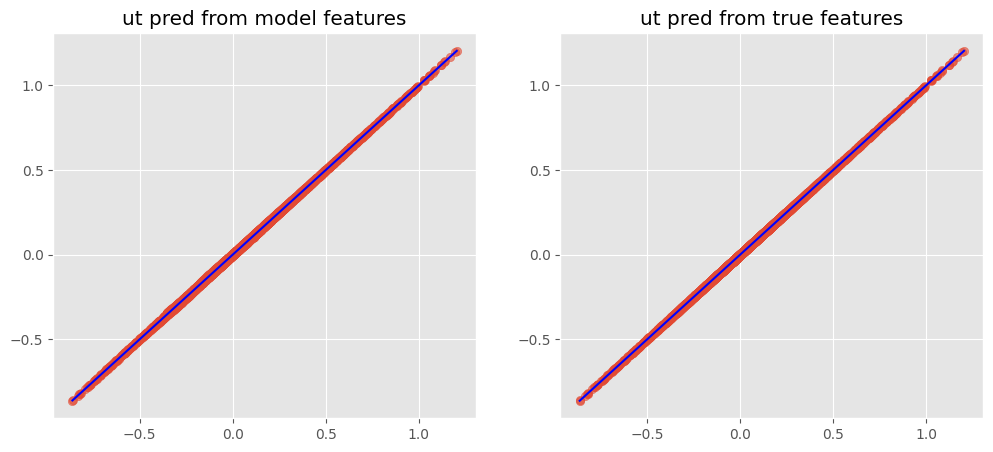

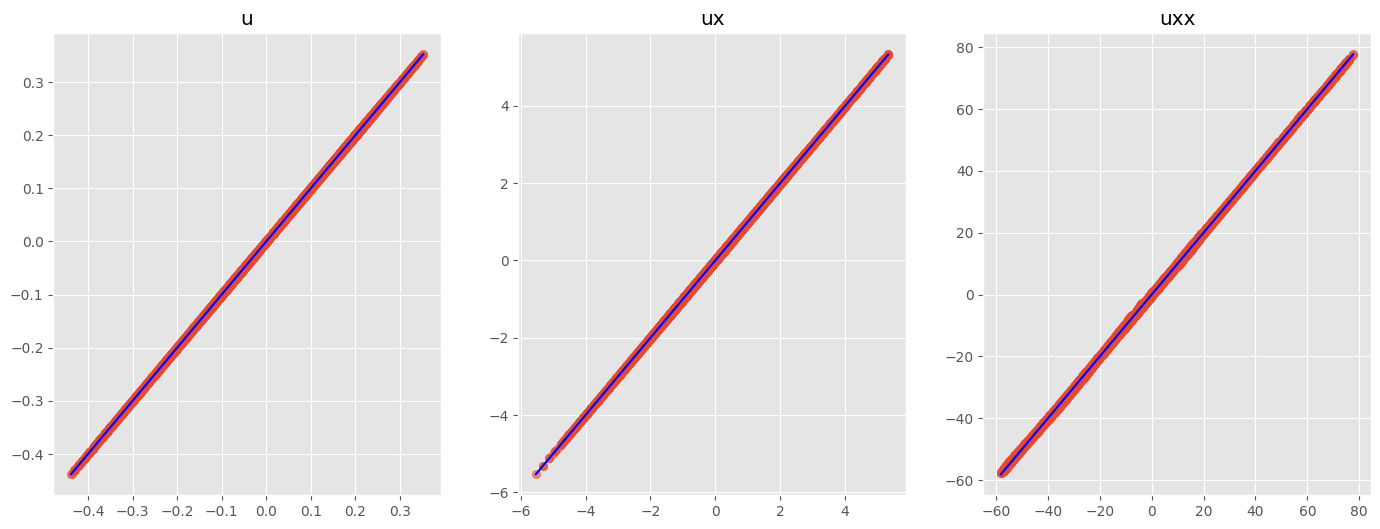

In [27]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,0],true_features[:,0])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,1],true_features[:,1])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,2],true_features[:,2])
plt.show()


In [28]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

def get_clipped_nrmse(true,pred, perc = 1):
    pred_clipped = jnp.clip(pred,jnp.percentile(pred,perc),jnp.percentile(pred,100-perc))
    true_clipped = jnp.clip(true,jnp.percentile(true,perc),jnp.percentile(true,100-perc))
    return get_nrmse(true_clipped,pred_clipped)


def get_nmae(true,pred):
    return jnp.mean(jnp.abs(true-pred))/jnp.mean(jnp.abs(true))

print("Normalized RMSE")
print("Optimized model feature predictions ",get_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features_init))

print("Clipped Normalized RMSE")
print("Optimized model feature predictions ",get_clipped_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_clipped_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features_init))


print("Normalized MAE")
print("Optimized model feature predictions ",get_nmae(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nmae(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nmae(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nmae(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nmae(ut_true,P_preds_init_model_features_init))

Normalized RMSE
Optimized model feature predictions  0.007031694511831947
Optimized true feature predictions  0.00024402420905772046
2 step model feature predictions  0.6357938274398627
2 step true feature predictions  0.6360613084140635
2 step init model feature predictions  0.6598452209515469
Clipped Normalized RMSE
Optimized model feature predictions  0.007279700780847646
Optimized true feature predictions  0.00023651308999733648
2 step model feature predictions  0.6418913607360043
2 step true feature predictions  0.6421978912144634
2 step init model feature predictions  0.6680421316888623
Normalized MAE
Optimized model feature predictions  0.005069155447158287
Optimized true feature predictions  0.00019560986343513062
2 step model feature predictions  0.622304807488525
2 step true feature predictions  0.6218996805590309
2 step init model feature predictions  0.6738718645953836


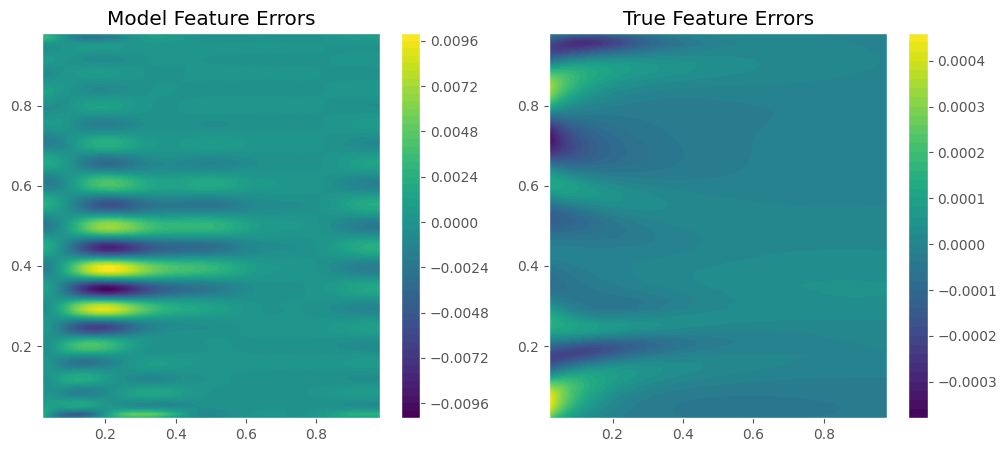

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Model Feature Errors")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,50,)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("True Feature Errors")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_true_features,50,)
plt.colorbar()

plt.show()

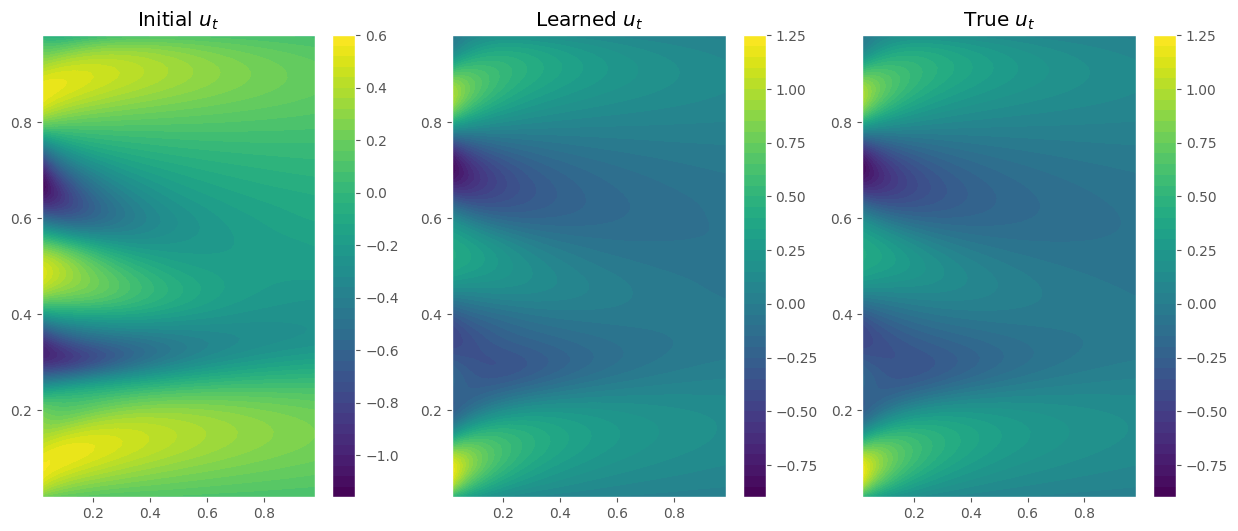

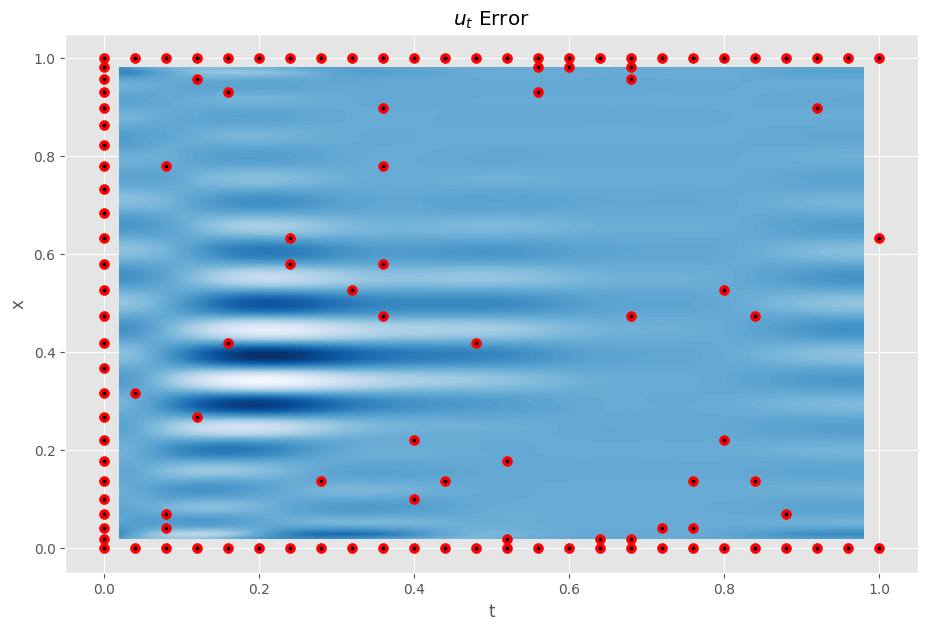

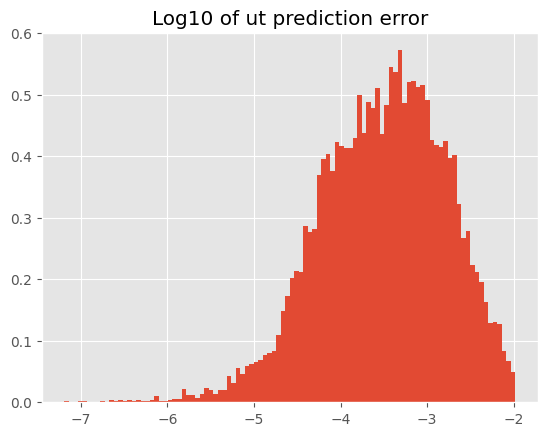

In [30]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.title("Initial $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],P_preds_init_model_features,50)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.colorbar()

plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()

## Test on a new initial condition

  0%|          | 0/2019 [00:00<?, ?it/s]

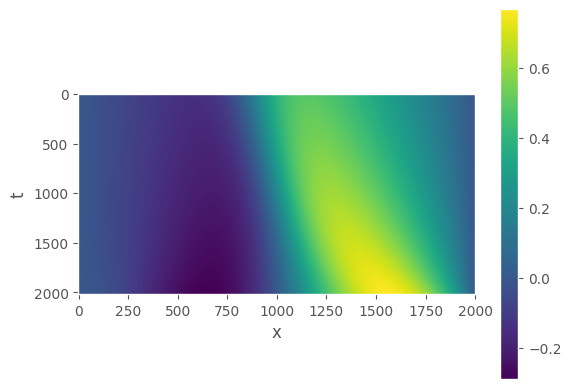

In [31]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def new_func_u0(x):
    u0 = -1 * x * jnp.sin(2 * jnp.pi * x)
    return u0

grid,solver = get_burger_solver(alpha,kappa,k,n = 1999)

u0_new = new_func_u0(grid)[1:-1]

sols_new,tvals = solver(u0_new,1.01)
sols_new = np.hstack([np.zeros((len(sols_new),1)),sols_new,np.zeros((len(sols_new),1))])

new_interp = RectBivariateSpline(tvals,grid,sols_new)
def new_u_true_function(x):
    return new_interp(x[:,0],x[:,1],grid = False)


plt.imshow(sols_new[::-1],aspect = 0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.colorbar()

In [32]:
@jit
def get_pred_ut(input_features):
    return P_model.kernel_function(input_features,model_grid_features)@P_sol
tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])

new_obs = new_u_true_function(tx_init_bdy)


class PdeModel():
    datafit_weight = 5.
    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
        grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
        return grid_features
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators([dt_k],tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_init_bdy,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = PdeModel.eval_obs_points(u_params)
        return new_obs - obs_preds
    
    @jit
    def equation_residual(u_params):
        P_features = PdeModel.get_grid_features(u_params)
        P_model_preds = get_pred_ut(P_features)
        ugrid_target = PdeModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(u_params):
        eqn_res = PdeModel.equation_residual(u_params)
        data_res = PdeModel.datafit_residual(u_params)
        return jnp.hstack([
            PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(u_params):
        return jnp.linalg.norm(PdeModel.F(u_params))**2
    
    @jit
    def damping_matrix(u_params):
        return u_model.kmat+1e-5 * diagpart(u_model.kmat)

In [34]:
new_u_init = 0*u_sol

u_params_pde,loss_vals_pde,JtRes_pde,improvement_ratios_pde,alpha_vals_pde,iterate_history_pde = LevenbergMarquadtMinimize(
    new_u_init.copy(),
    PdeModel,
    beta = 0.,
    max_iter = 101,
    init_alpha=0.05,
    line_search_increase_ratio=1.4,
    print_every = 10
)

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.06422, Jres = 186.9, alpha = 0.04167, improvement_ratio = 0.9683
Iteration 1, loss = 0.009162, Jres = 59.88, alpha = 0.03472, improvement_ratio = 0.9732
Iteration 2, loss = 0.003369, Jres = 8.863, alpha = 0.02894, improvement_ratio = 0.9931
Iteration 3, loss = 0.001798, Jres = 3.346, alpha = 0.02411, improvement_ratio = 1.003
Iteration 4, loss = 0.0012, Jres = 1.507, alpha = 0.02009, improvement_ratio = 1.004
Iteration 5, loss = 0.0009074, Jres = 0.7369, alpha = 0.01674, improvement_ratio = 1.002
Iteration 10, loss = 0.0003804, Jres = 0.06485, alpha = 0.006729, improvement_ratio = 0.9997
Iteration 20, loss = 0.0001277, Jres = 0.004405, alpha = 0.001087, improvement_ratio = 0.9998
Iteration 30, loss = 5.918e-05, Jres = 0.0006025, alpha = 0.0001755, improvement_ratio = 0.9999
Iteration 40, loss = 2.918e-05, Jres = 0.000181, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 1.548e-05, Jres = 6.28e-05, alpha = 4.579e-06, improvement_ratio = 1.0
Iteration

In [35]:
reg_sequence = np.hstack(
    [
        10 ** jnp.arange(-4, -11, -0.25),
        5e-12 * np.ones(10),
        1e-15 * np.ones(5),
        5e-16 * np.ones(15),
        1e-16 * np.ones(15),
        ]
        )
u_pde_adj,refinement_losses_pde = refine_solution(u_params_pde,PdeModel,reg_sequence)


  0%|          | 0/73 [00:00<?, ?it/s]

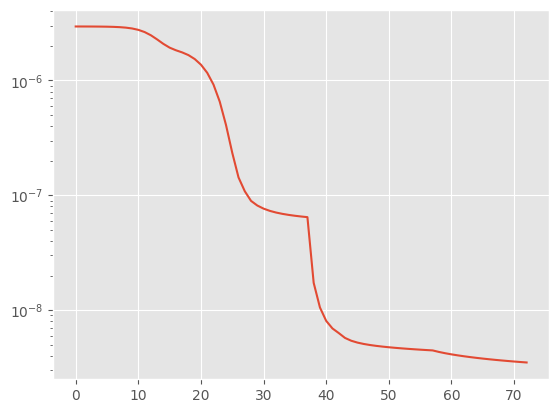

In [36]:
plt.plot(refinement_losses_pde)
plt.yscale('log')

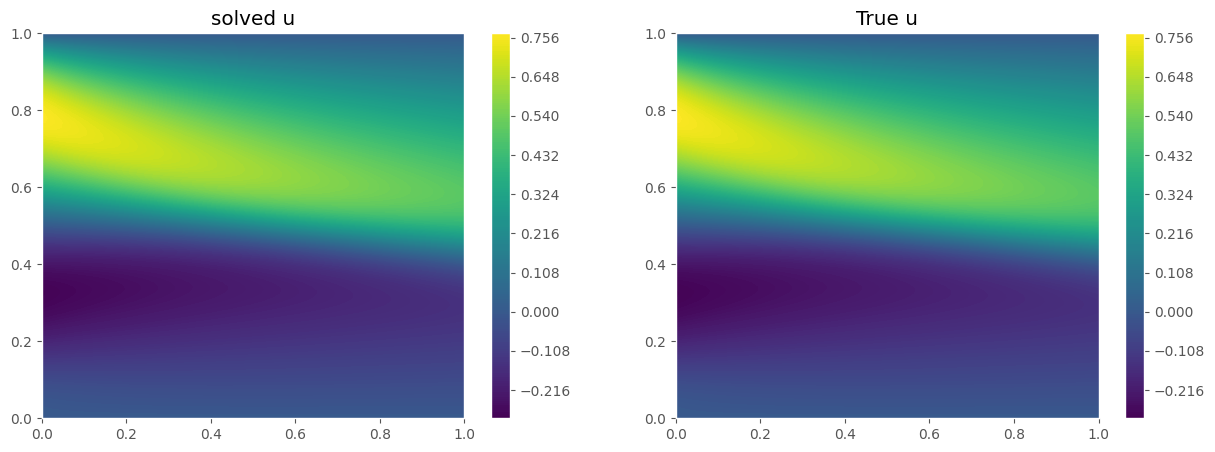

In [37]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

new_u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_pde_adj)

new_u_true_fine = new_u_true_function(tx_grid_fine)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("solved u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_eval_fine,200)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine,200)
plt.colorbar()


Text(0.5, 1.0, 'Error')

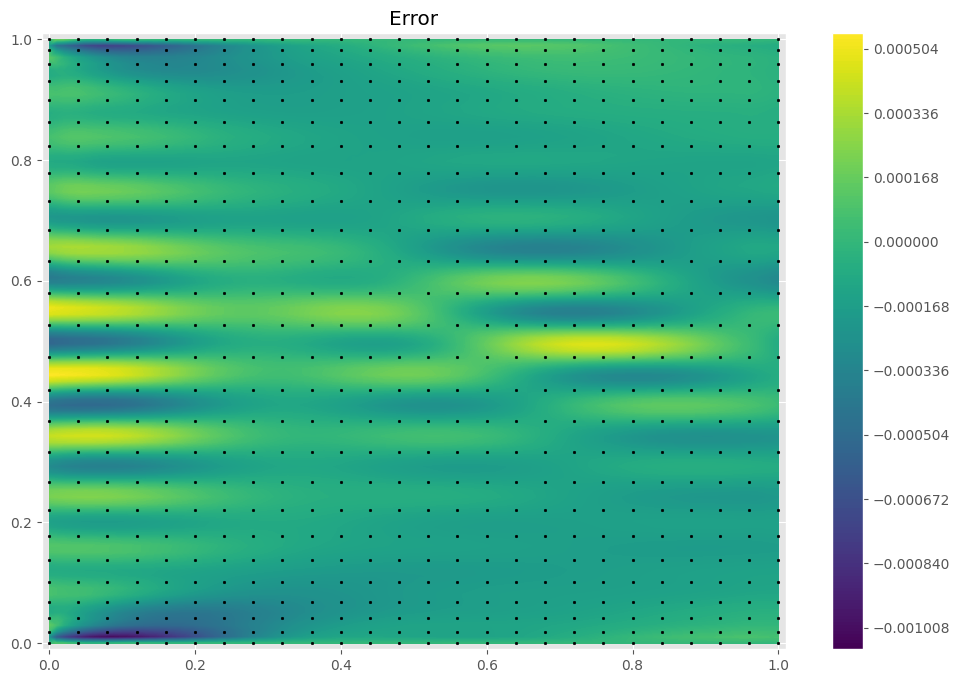

In [38]:
plt.figure(figsize=(12,8))
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine-new_u_eval_fine,200)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],s = 3,c='black')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.title("Error")

In [40]:
jnp.max(jnp.abs(new_u_true_fine-new_u_eval_fine))

Array(0.00106275, dtype=float64)

In [42]:
get_nrmse(new_u_true_fine,new_u_eval_fine)

Array(0.00052219, dtype=float64)

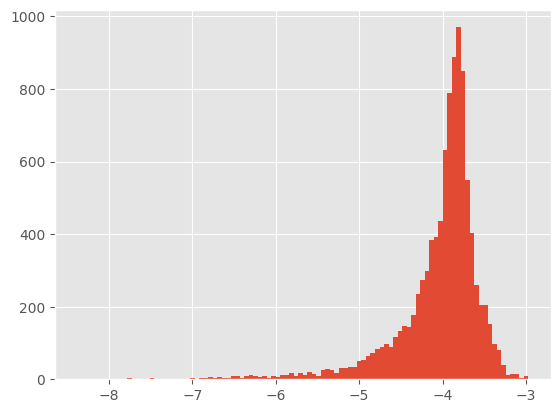

In [43]:
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine)),100)
plt.show()